In [12]:
import numpy as np
from pathlib import Path
import pyvista as pv
import sys
import plotly.graph_objects as go

In [13]:
sys.path.append(str(Path.cwd().parent))

In [14]:
from comsol_module.comsol_classes import COMSOL_VTU
from comsol_module.helper import calculate_normal
from src.utils import read_config

In [15]:
config = read_config()
IS_SAVE_PNG = True
ACCURACY = 1e-5
PARAMETER_SPACE = "07"
SUFFIX = "mean" #"init_diff"

ROOT = Path().cwd().parent / "data" / PARAMETER_SPACE / "TrainingMapped" / "s100_100_100_b0_4000_0_5000_-4000_-0"
ROOT = Path().cwd().parent / "data" / PARAMETER_SPACE 
assert ROOT.exists()

### Import

In [16]:
basis_functions_array = [path for path in (ROOT / "BasisFunctionsEntropy").rglob('basis_fts_matrix_*.npy')]
information_content_array = [path.with_stem(path.stem.replace('basis_fts_matrix_', 'information_content_')) for path in basis_functions_array]

In [17]:
comsol_data_path = [path for path in ROOT.rglob("*.vtu")][0]
comsol_data = COMSOL_VTU(comsol_data_path)
print(comsol_data.vtu_path)

/Users/thomassimader/Library/CloudStorage/OneDrive-geomeconGmbH/PhD/NIRB/data/07/TrainingOriginal/Training_120.vtu


In [18]:
normal = calculate_normal(60, 90)

### Plot

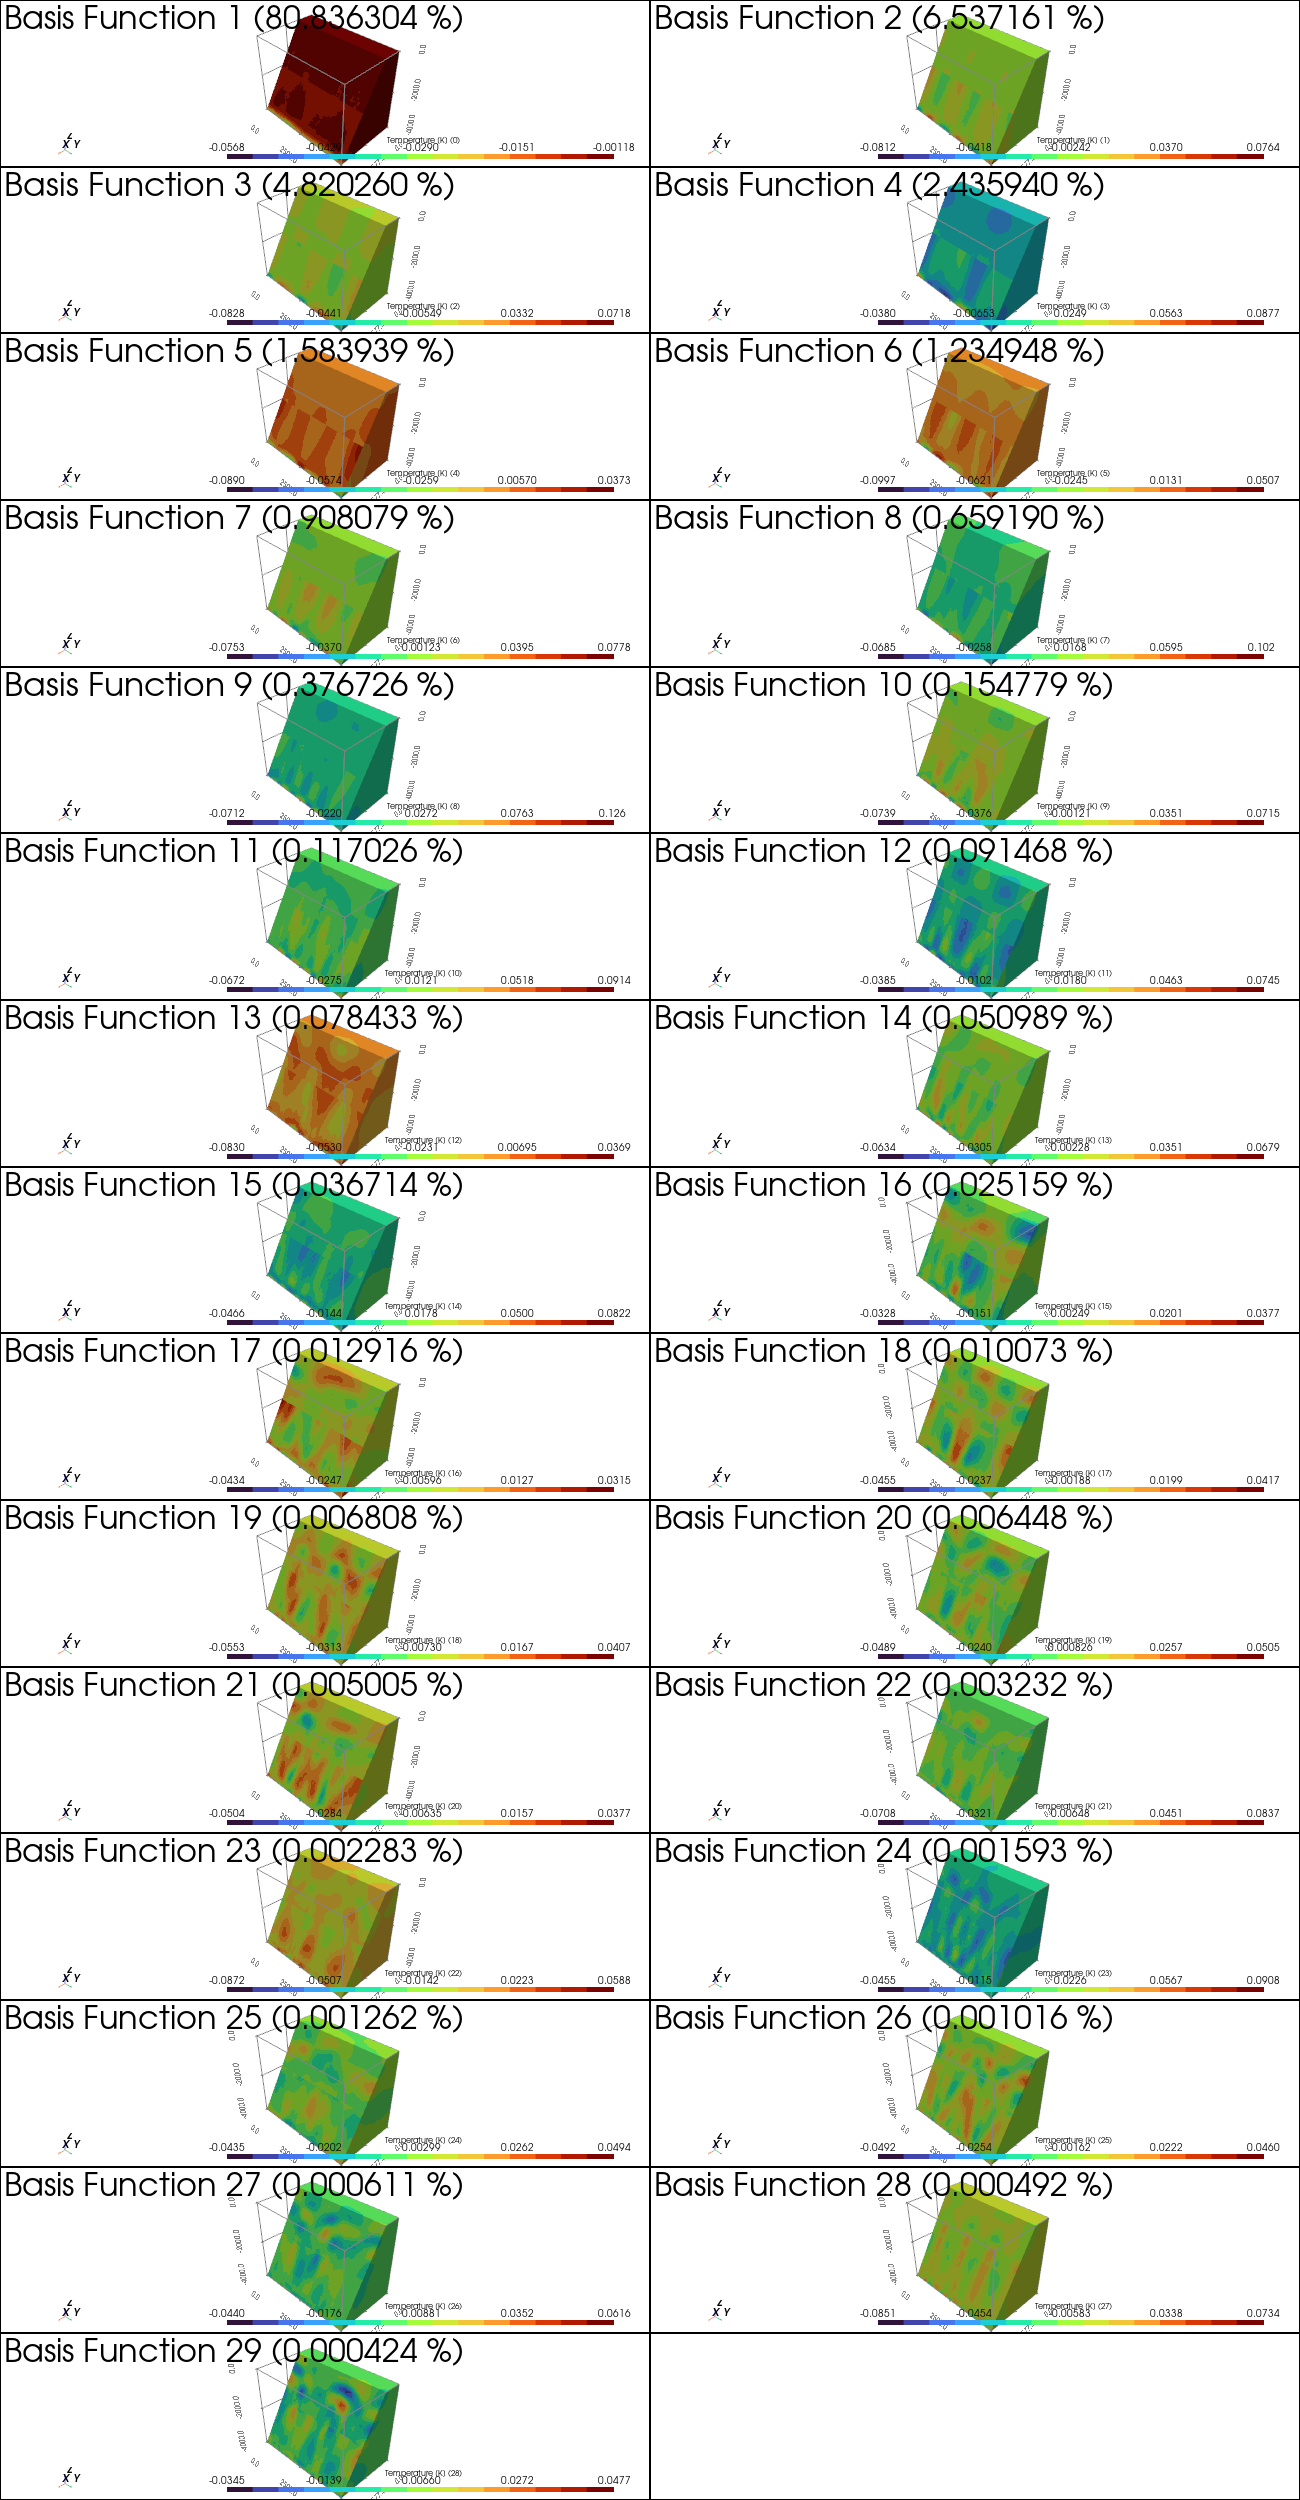

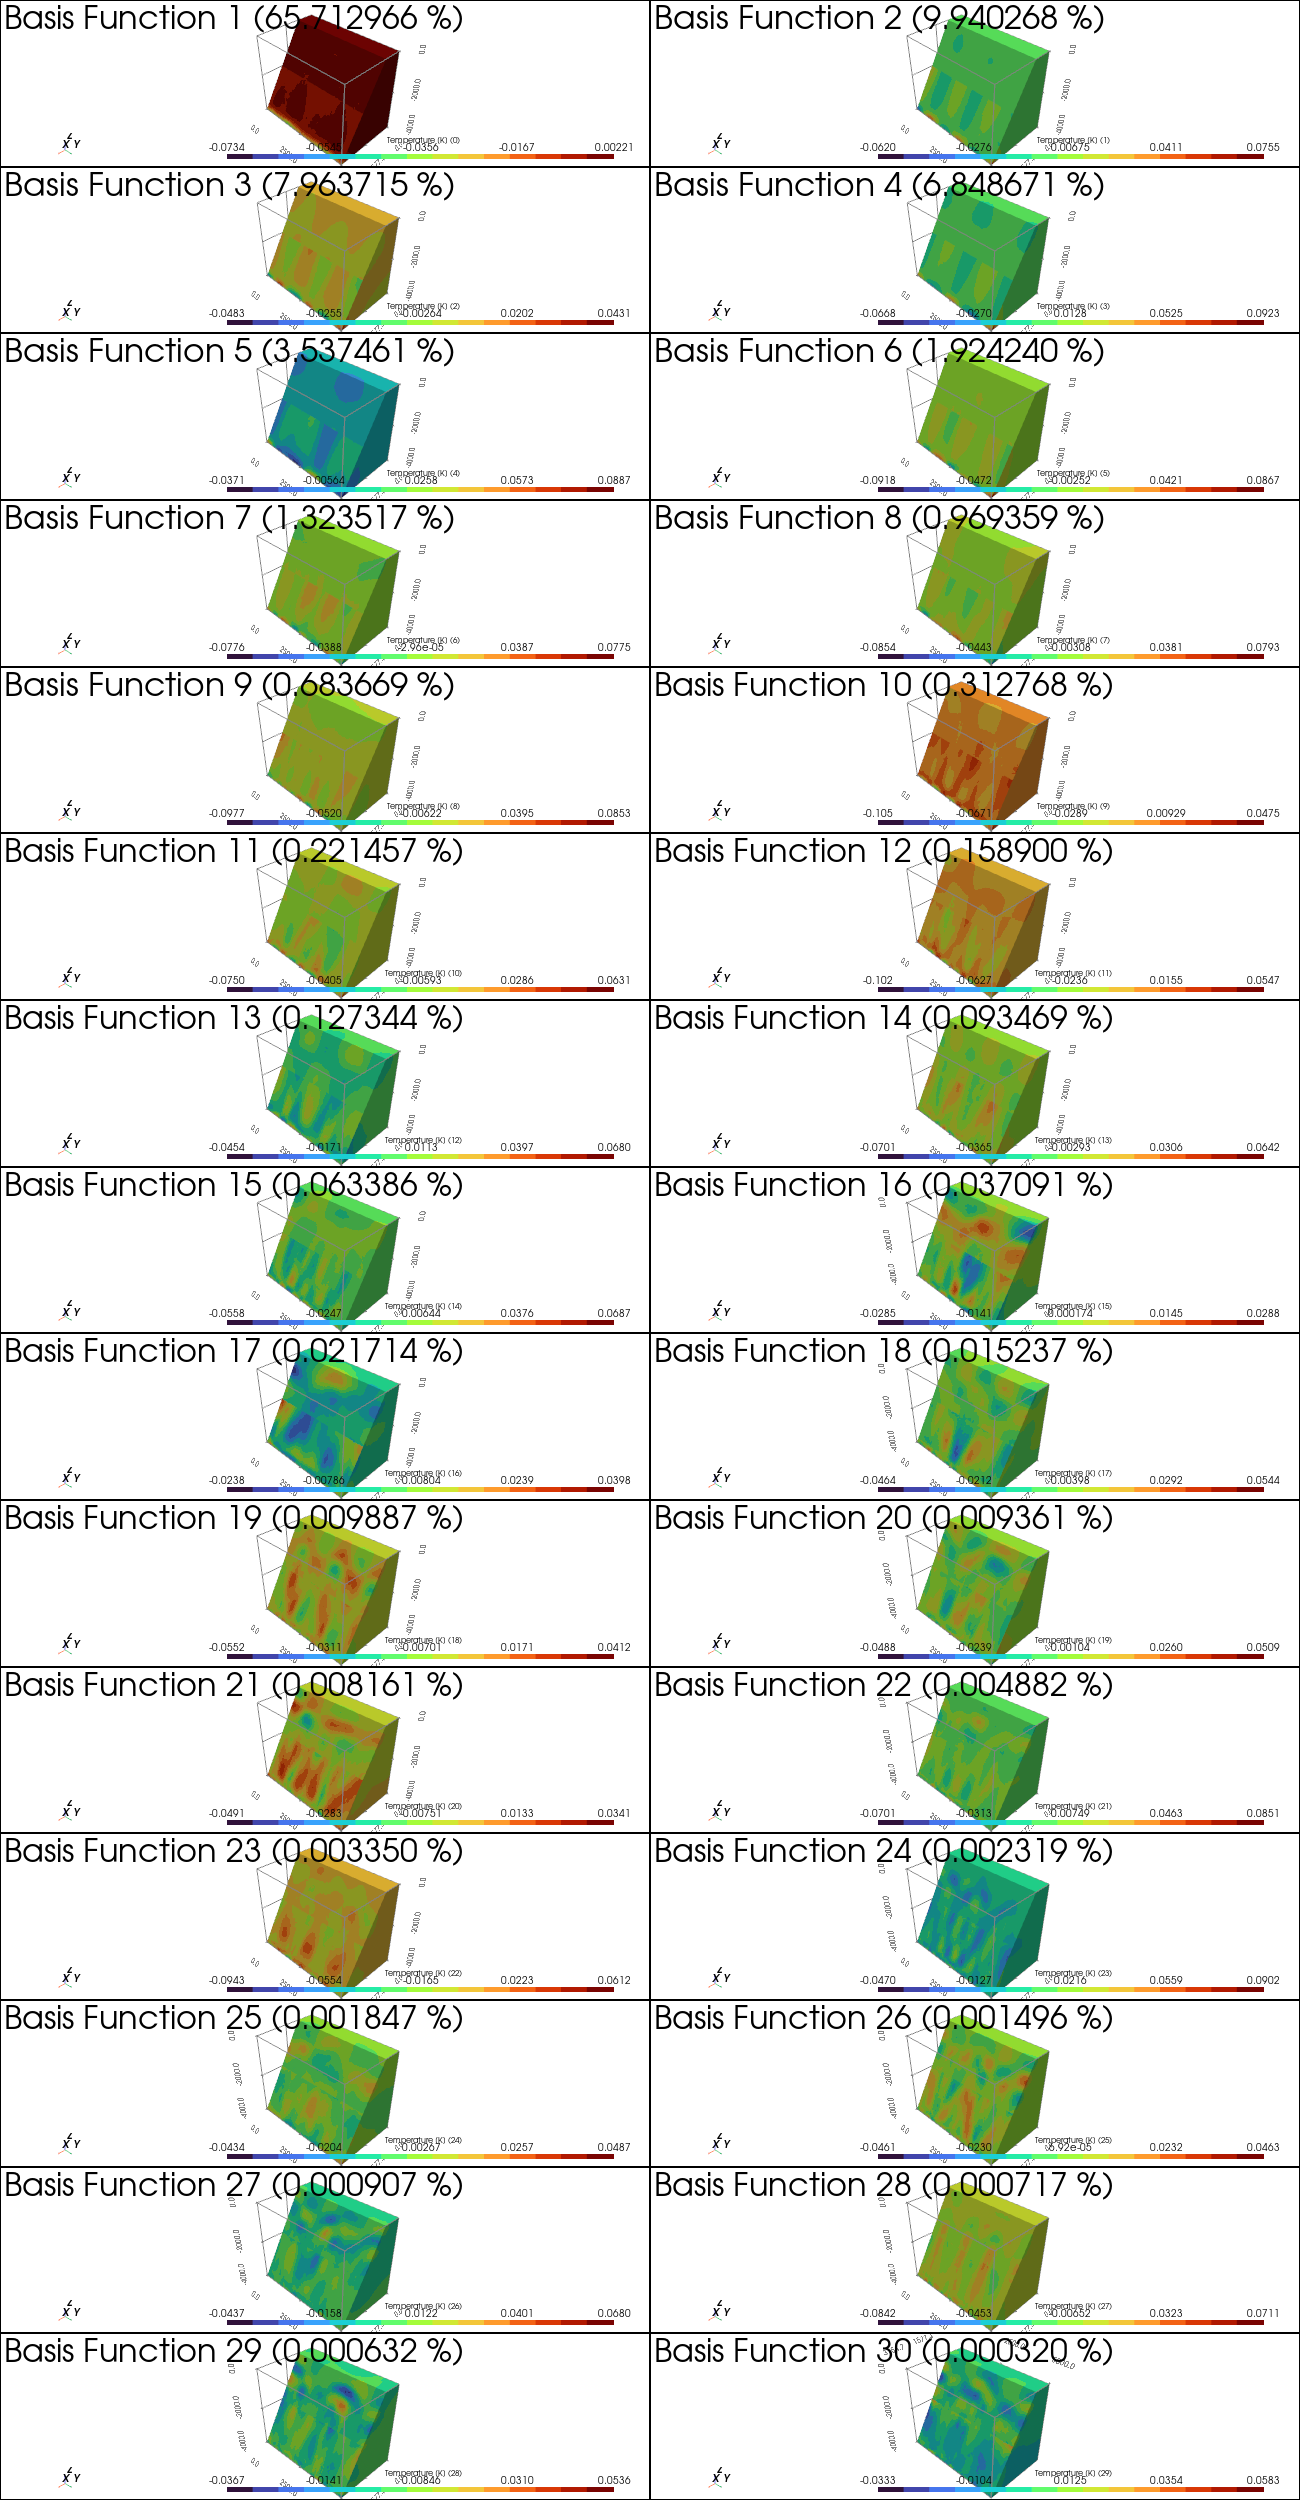

In [19]:
pv.set_jupyter_backend('static')

for basis_functions_path, information_content_path in zip(basis_functions_array, information_content_array):
    basis_functions = np.load(basis_functions_path)
    information_content = np.load(information_content_path)
    n_cols = 2  # number of columns you want
    n_rows = int(np.ceil(basis_functions.shape[0] / n_cols))  # calculate required number of rows
    plotter = pv.Plotter(shape=(n_rows, n_cols),
                        window_size=(1300, 2500),
                        title=f"Basis functions - Parameter Space {PARAMETER_SPACE}")
    counter = 0
    for i in range(n_rows):
        for j in range(n_cols):
            plotter.subplot(i, j)
            field_name = f"basis_function{i}"
            if counter >= basis_functions.shape[0]:
                break
            comsol_data.mesh.point_data[field_name] = basis_functions[counter, :]
            # clip along fault plane
            clipped = comsol_data.mesh.clip(normal=-np.array(normal), origin = comsol_data.mesh.center)
            # clipped = comsol_data.mesh.slice_along_axis(n=5, axis='x')
            # clipped = comsol_data.mesh
            
            plotter.add_mesh(clipped, scalars=field_name,
                                cmap=config['cmap'], 
                                # clim = [clim_min, clim_max],
                                scalar_bar_args={'title': f'Temperature [K] ({counter})',
                                                'label_font_size': 10,
                                                'title_font_size': 8,})
            text_string = f"Basis Function {counter + 1}"
            try:
                text_string = text_string + f" ({information_content[counter] * 100:.6f} %)"
            except( NameError , IndexError):
                pass
            plotter.add_text(text_string)
            plotter.add_axes(line_width=1.)
            plotter.add_bounding_box()
            plotter.show_grid(
                font_size=6,
                # location='outer',
                n_xlabels=3,  # number of labels (ticks) on x-axis
                n_ylabels=3,  # number of labels (ticks) on y-axis
                n_zlabels=3,  # number of labels (ticks) on z-axis
                color='gray',
                xtitle='',
                ytitle='',
                ztitle='',
                            )
            counter += 1

    kwargs = {}
    if IS_SAVE_PNG:
        plotter.screenshot(basis_functions_path.with_suffix('.png'))
    plotter.show()

### Data Set

In [20]:
for basis_functions_path, information_content_path in zip(basis_functions_array, information_content_array):
    basis_functions = np.load(basis_functions_path)
    information_content = np.load(information_content_path)

    n_points = np.arange(basis_functions.shape[1])
    lw = 0.5

    fig = go.Figure()

    y_min, y_max = np.min(basis_functions), np.max(basis_functions)
    for idx, basis_function in enumerate(basis_functions, start=1):
        fig.add_trace(
            go.Scatter(x=n_points,
                    y=basis_function,
                    mode='lines',
                    line_shape='hv', 
                    opacity=0.5,
                    line=dict(width=lw),
                    showlegend=True,
                    hoverinfo='skip',
                    name = f"Basis Function {idx}",
        ))
        
        # fig.update_yaxes(title_text="Scaled T [-]", range = [y_min, y_max], row=idx, col=1)


    # Update axes labels
    fig.update_xaxes(title_text="Point ID [-]")

    # Set overall layout
    fig.update_layout(
        width=1500, height=1400,
        title_text=f"Parameter Space {PARAMETER_SPACE}",
        showlegend=True,
        legend=dict(
            orientation='h',        # Horizontal layout
            yanchor='top',          # Anchor legend at the top
        ),
    )
    if IS_SAVE_PNG:
        fig.write_image(basis_functions_path.parent / (basis_functions_path.stem + '_data_set.png'))

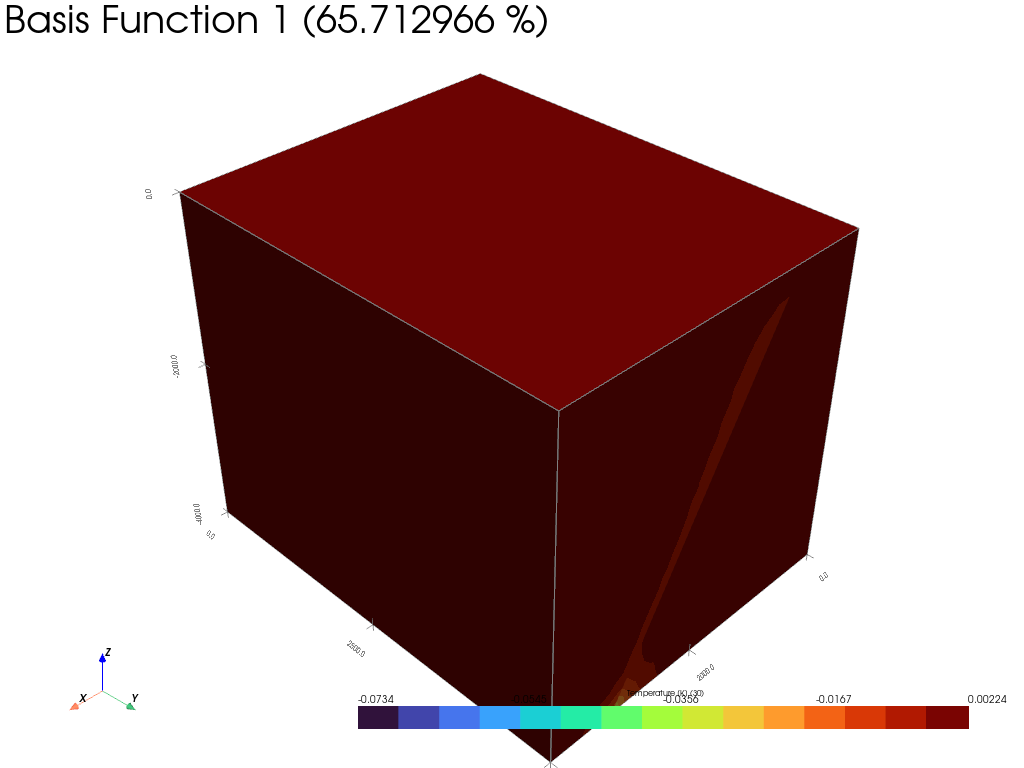

In [21]:

plotter = pv.Plotter()
basis_function_id : int = 0

comsol_data.mesh.point_data[field_name] = basis_functions[basis_function_id, :]
# clip along fault plane
# clipped = comsol_data.mesh.clip(normal=-np.array(normal), origin = comsol_data.mesh.center)
# clipped = comsol_data.mesh.slice_along_axis(n=5, axis='x')
clipped = comsol_data.mesh

plotter.add_mesh(clipped, scalars=field_name,
                    cmap=config['cmap'], 
                    # clim = [clim_min, clim_max],
                    scalar_bar_args={'title': f'Temperature [K] ({counter})',
                                    'label_font_size': 10,
                                    'title_font_size': 8,})
text_string = f"Basis Function {basis_function_id + 1}"
try:
    text_string = text_string + f" ({information_content[basis_function_id] * 100:.6f} %)"
except( NameError , IndexError):
    pass
plotter.add_text(text_string)
plotter.add_axes(line_width=1.)
plotter.add_bounding_box()
plotter.show_grid(
    font_size=6,
    # location='outer',
    n_xlabels=3,  # number of labels (ticks) on x-axis
    n_ylabels=3,  # number of labels (ticks) on y-axis
    n_zlabels=3,  # number of labels (ticks) on z-axis
    color='gray',
    xtitle='',
    ytitle='',
    ztitle='',
                    )
counter += 1

kwargs = {}
# if IS_SAVE_PNG:
    # kwargs["screenshot"] = ROOT /  "BasisFunctions" / f"basis_functions_PS{PARAMETER_SPACE}_{ACCURACY:.1e}_{SUFFIX}.png"
plotter.show(**kwargs)